# Pneumonia Classification in Chest X-rays using CNN



 Convolutional Neural Networks (CNNs)

In the field of deep learning, the ability of machines to interpret visual data has been revolutionized by architectures that mimic biological processes. As O’Shea and Nash (2015) point out in their foundational work:

> "Artificial Neural Networks (ANNs) are computational processing systems of which are heavily inspired by way biological nervous systems (such as the human brain) operate."

This biological inspiration led to the development of **Convolutional Neural Networks (CNNs)**, a specialized class of networks designed to solve the inherent limitations of traditional architectures when dealing with high-dimensional data. Before CNNs, processing images meant "flattening" pixels into a single vector, a process that not only exploded the number of parameters to an unmanageable scale but also completely ignored the spatial hierarchy—the relationship between neighboring pixels that forms shapes and objects.

CNNs address these challenges through the mathematical operation of **convolution**, which allows the network to learn local patterns (such as edges, textures, and colors) that are invariant to their position in the image. By stacking convolutional layers and pooling operations, these networks can abstract simple features into complex concepts, making them the standard for a wide range of applications: from medical diagnosis in X-rays and MRI scans to the real-time perception systems of autonomous vehicles.

You can find more details in the original paper: [An Introduction to Convolutional Neural Networks](https://arxiv.org/abs/1511.08458)



This notebook presents the development of a Convolutional Neural Network (CNN) designed to detect pneumonia from **chest X-ray images**.

### 1. Environment Setup and Imports

In this section, the necessary libraries for tensor processing (PyTorch), visualization (Matplotlib), and evaluation metrics were loaded.



In [2]:

# Core deep learning libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Data handling
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# Numerical and visualization
import numpy as np
import matplotlib.pyplot as plt

# Evaluation
from sklearn.metrics import confusion_matrix, classification_report

# System
import os
import sys

### 2. Data Loading and Preprocessing

The system paths were configured to access local modules and the dataloaders were initialized. An image size of 228x228 was selected to balance detail and computational cost.


In [5]:
# Go up one level to reach the project root and enter 'src'
sys.path.append(os.path.abspath(os.path.join('..')))

# Import custom dataloaders
from src.data.dataloaders import get_loaders

# Execute the function to get data loaders
# batch_size=32 is a stable standard for training
train_loader, test_loader = get_loaders(batch_size=32, img_size=228)

print(f"train_loader variable defined: {train_loader is not None}")

train_loader variable defined: True


### 3. Model Architecture (PneumoniaCNN)

A custom architecture with 3 convolutional blocks was designed. Each block extracted features ranging from low-level edges to high-level lung opacity patterns.


In [6]:
class PneumoniaCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(PneumoniaCNN, self).__init__()
        
        # BLOCK 1: Initial feature extraction
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # BLOCK 2: Depth increase
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # BLOCK 3: Complex features extraction
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            # Output size: 28x28x128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.flatten = nn.Flatten()
        
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5), # Regularization was added to prevent overfitting
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.flatten(x)
        x = self.fc_layers(x)
        return x

# The model was instantiated and dimensions were verified
model = PneumoniaCNN(num_classes=2)
print("Model structure was successfully verified.")

Model structure was successfully verified.


### 4. Training Configuration

The hardware was selected. Since an Apple M1 chip was used, the Metal Performance Shaders (MPS) backend was prioritized to leverage the integrated GPU, falling back to CPU only if necessary.


In [12]:
# Hardware selection (Optimized for Apple M1/M2/M3)
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Training on: Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Training on: NVIDIA GPU (CUDA)")
else:
    device = torch.device("cpu")
    print("Training on: CPU")

model = model.to(device)

# CrossEntropyLoss was chosen for classification
criterion = nn.CrossEntropyLoss()

# Adam optimizer was initialized with a learning rate of 1e-4 and weight decay

optimizer = optim.Adam(
    model.parameters(),
    lr=5e-5,
    weight_decay=1e-4  
)


# A scheduler was implemented to reduce LR on plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

Training on: Apple Silicon GPU (MPS)


### 5. Training Loop Definition

A function was created to manage the training process, error calculation, and weight optimization.


In [13]:
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10, patience=3):
    history = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}

    best_loss = float("inf")
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct_train / total_train
        
        # Validation phase
        model.eval()
        test_loss, correct_test, total_test = 0.0, 0, 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        
        test_loss = test_loss / len(test_loader)
        test_acc = 100 * correct_test / total_test

        
        # Metrics were stored in history
        history['train_loss'].append(epoch_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(epoch_acc)
        history['test_acc'].append(test_acc)
        
        print(f"Epoch [{epoch+1}/{epochs}] - "
      f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}% - "
      f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%",
        flush=True
        )

        # Save the best model based on test loss with early stopping
        if test_loss < best_loss:
            best_loss = test_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), "best_model.pth")
            print("Best model saved")
        else:
            epochs_no_improve += 1
            print(f"No improvement ({epochs_no_improve}/{patience})")

            if epochs_no_improve >= patience:
                print("Early stopping triggered")
                break

   

        
    return history

### 6. Visualization of Results

A set of functions was developed to monitor the model's convergence during the training process. These visualizations allowed for a direct comparison between the training and testing datasets, ensuring that the learning rate and architecture were appropriate for the task.


In [14]:
def plot_results(history):
    plt.figure(figsize=(14, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['test_loss'], label='Test')
    plt.title('Loss History')
    plt.legend()
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['test_acc'], label='Test')
    plt.title('Accuracy History')
    plt.legend()
    
    plt.show()

#### Training Analysis: Early Stopping and Loss Convergence

To ensure the model's ability to generalize and prevent overfitting, the training history was analyzed. A specific visualization was implemented to identify the optimal point where the Validation Loss reached its minimum. This point represents the best version of the model before it started to memorize the training data (overfitting).

In [15]:
def plot_loss_with_early_stop(history):
    best_epoch = history['test_loss'].index(min(history['test_loss']))

    plt.figure(figsize=(7, 5))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['test_loss'], label='Test Loss')

    plt.axvline(best_epoch, linestyle='--', color='red', label='Early Stop')
    plt.scatter(best_epoch, history['test_loss'][best_epoch], color='red', zorder=5)

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss + Early Stopping')
    plt.legend()
    plt.show()


### 7. Experiment Execution

The training process was executed for 10 epochs and the results were visualized.


Epoch [1/10] - Train Loss: 0.1198, Train Acc: 95.48% - Test Loss: 0.7521, Test Acc: 78.21%
Best model saved
Epoch [2/10] - Train Loss: 0.1101, Train Acc: 95.94% - Test Loss: 0.6582, Test Acc: 79.33%
Best model saved
Epoch [3/10] - Train Loss: 0.1027, Train Acc: 95.82% - Test Loss: 0.8711, Test Acc: 74.84%
No improvement (1/3)
Epoch [4/10] - Train Loss: 0.1056, Train Acc: 96.09% - Test Loss: 0.7068, Test Acc: 76.92%
No improvement (2/3)
Epoch [5/10] - Train Loss: 0.1036, Train Acc: 96.22% - Test Loss: 0.8406, Test Acc: 76.44%
No improvement (3/3)
Early stopping triggered


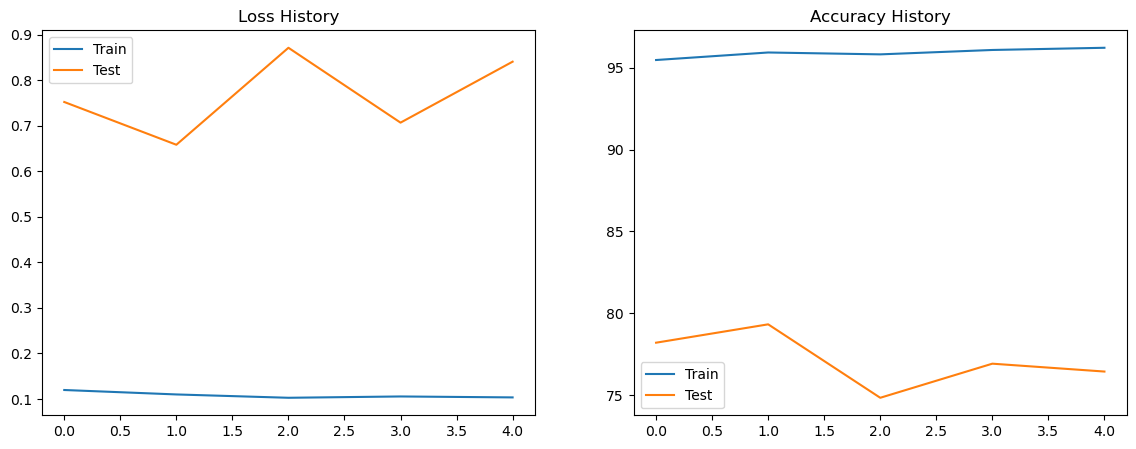

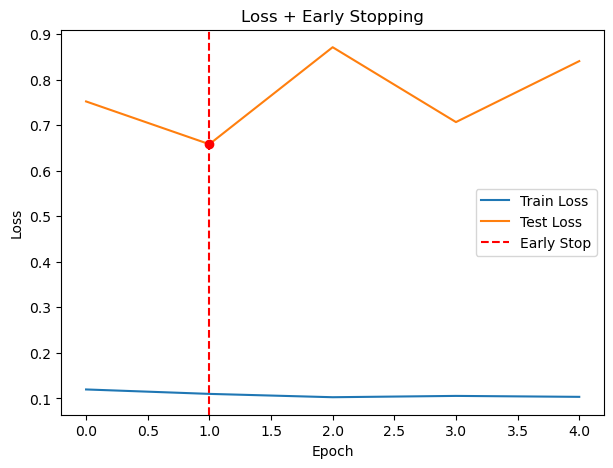

In [16]:
# Define number of epochs
NUM_EPOCHS = 10 
PATIENCE = 3

# Train the model
history = train_model(
    model, 
    train_loader, 
    test_loader, 
    criterion, 
    optimizer, 
    epochs=NUM_EPOCHS,
    patience=PATIENCE
)

# Plot the training results
plot_results(history)
plot_loss_with_early_stop(history)
